In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [4]:
df = pd.read_excel('online_retail_data.xlsx')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df_copy = df.copy()

# Data Discovery

- 4372 Unique CustomerID values
- 25900 Unique InvoiceNo values
- 4070 Unique StockCode values
- 38970 max unit price
- 0.03 min unit price
- 9,287 returns
- date range is (2010-12-01 to 2011-12-09)

In [6]:
df[df.StockCode == 'B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [7]:
df = df[df.StockCode != 'B']

A few items that are less than 0.01 and the quantity doesn't bring them to 0.01 will also be dropped

In [8]:
df = df[df.UnitPrice > .01]

In [9]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [40]:
grouped_customers = df.groupby(['CustomerID', 'InvoiceNo']).sum()
grouped_customers.head()

Quantity  UnitPrice  TotalRevenue
CustomerID InvoiceNo                                   
12346.0    541431        74215       1.04      77183.60
           C541433      -74215       1.04     -77183.60
12347.0    537626          319      89.59        711.79
           542237          315      73.17        475.39
           549222          483      62.29        636.25

In [12]:
df.isna().sum()

InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      132602
Country              0
TotalRevenue         0
dtype: int64

In [41]:
invoice_count = df.groupby(['CustomerID'], as_index=False)['InvoiceNo'].count()
invoice_count.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [14]:
customer_total_revenue = df.groupby(['CustomerID'], as_index=False)['TotalRevenue'].sum()

In [15]:
customer_total_revenue.head(2)

,CustomerID,TotalRevenue
0,12346.0,0.0
1,12347.0,4310.0


In [16]:
customer_total_revenue.TotalRevenue = round(customer_total_revenue.TotalRevenue, 2)

In [17]:
customer_total_revenue_invoice_count = customer_total_revenue.merge(invoice_count, on='CustomerID', sort=True)

In [18]:
customer_total_revenue_invoice_count = customer_total_revenue_invoice_count[customer_total_revenue_invoice_count['TotalRevenue'] > 0]

In [19]:
customer_total_revenue_invoice_count.head(2)

,CustomerID,TotalRevenue,InvoiceNo
1,12347.0,4310.00,182
2,12348.0,1797.24,31


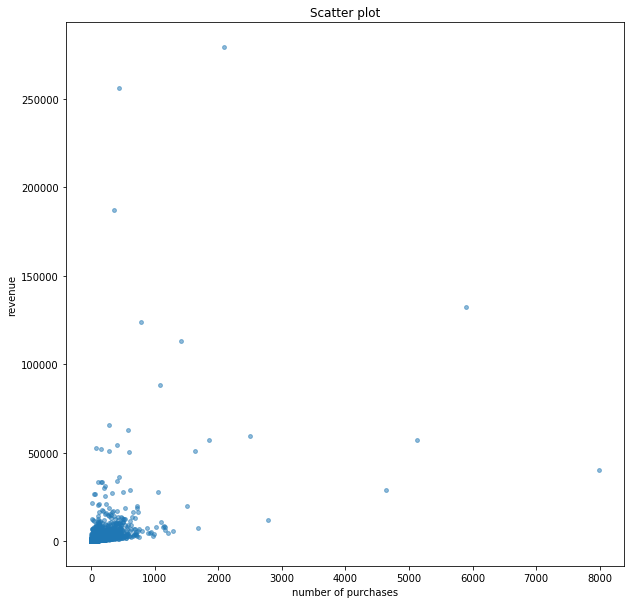

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(customer_total_revenue_invoice_count.InvoiceNo, customer_total_revenue_invoice_count.TotalRevenue, s=15, alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.show()


In [21]:
customer_total_revenue_invoice_count.describe()

,CustomerID,TotalRevenue,InvoiceNo
count,4317.000000,4317.000000,4317.000000
mean,15300.118369,1925.712798,94.091267
std,1720.237942,8267.659420,233.709977
min,12347.000000,2.900000,1.000000
25%,13815.000000,302.700000,18.000000
50%,15299.000000,658.260000,43.000000
75%,16778.000000,1627.130000,103.000000
max,18287.000000,279489.020000,7983.000000


In [22]:
customer_total_revenue_invoice_count.head(2)

,CustomerID,TotalRevenue,InvoiceNo
1,12347.0,4310.00,182
2,12348.0,1797.24,31


In [23]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [24]:
df['DaysSincePurchase'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [25]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,DaysSincePurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [26]:
customer_since_purchase = df.groupby(['CustomerID'], as_index=False)['DaysSincePurchase'].min()

In [27]:
customer_total_revenue_invoice_count_since_purchase = customer_total_revenue_invoice_count.merge(customer_since_purchase, on='CustomerID', sort=True)

In [28]:
customer_total_revenue_invoice_count_since_purchase.head(2)

,CustomerID,TotalRevenue,InvoiceNo,DaysSincePurchase
0,12347.0,4310.00,182,1 days 20:58:00
1,12348.0,1797.24,31,74 days 23:37:00


In [29]:
import datetime
import math

In [30]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [31]:
customer_total_revenue_invoice_count_since_purchase['RecentPurchase'] = 0

In [32]:
RecentPurchase = customer_total_revenue_invoice_count_since_purchase['DaysSincePurchase']

In [33]:
customer_total_revenue_invoice_count_since_purchase.head()

,CustomerID,TotalRevenue,InvoiceNo,DaysSincePurchase,RecentPurchase
0,12347.0,4310.00,182,1 days 20:58:00,0
1,12348.0,1797.24,31,74 days 23:37:00,0
2,12349.0,1757.55,73,18 days 02:59:00,0
3,12350.0,334.40,17,309 days 20:49:00,0
4,12352.0,1545.41,95,35 days 22:13:00,0


In [34]:
RecentPurchaseDays = [None] * len(RecentPurchase)

In [35]:
RecentPurchase[0].days

1

In [36]:
for i in range(len(RecentPurchase)):
    RecentPurchaseDays[i] = (RecentPurchase[i].days) * 1.5

In [37]:
%%timeit

RecentPurchaseDays2 = RecentPurchase.apply(lambda x: abs(x.days - 373))

27.2 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
min(RecentPurchaseDays2)

NameError: name 'RecentPurchaseDays2' is not defined

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue), s=RecentPurchaseDays, alpha=0.3, c=RecentPurchaseDays,cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
sliced = len(customer_total_revenue_invoice_count_since_purchase)//7

In [ ]:
sliced

In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:sliced]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:sliced]), s=RecentPurchaseDays[0:sliced], alpha=0.3, c=RecentPurchaseDays[0:sliced],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:(sliced * 2)]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:(sliced * 2)]), s=RecentPurchaseDays[0:(sliced * 2)], alpha=0.3, c=RecentPurchaseDays[0:(sliced * 2)],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:(sliced * 3)]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:(sliced * 3)]), s=RecentPurchaseDays[0:(sliced * 3)], alpha=0.3, c=RecentPurchaseDays[0:(sliced * 3)],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:(sliced * 4)]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:(sliced * 4)]), s=RecentPurchaseDays[0:(sliced * 4)], alpha=0.3, c=RecentPurchaseDays[0:(sliced * 4)],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:(sliced * 5)]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:(sliced * 5)]), s=RecentPurchaseDays[0:(sliced * 5)], alpha=0.3, c=RecentPurchaseDays[0:(sliced * 5)],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:(sliced * 6)]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:(sliced * 6)]), s=RecentPurchaseDays[0:(sliced * 6)], alpha=0.3, c=RecentPurchaseDays[0:(sliced * 6)],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue), s=RecentPurchaseDays, alpha=0.3, c=RecentPurchaseDays,cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.show()


In [ ]:
len(customer_total_revenue_invoice_count_since_purchase)

In [ ]:
# i = 4317
for i in range(len(customer_total_revenue_invoice_count_since_purchase)):
    if i % 25 == 0 or i == 4317:
        plt.figure(figsize=(30,30))
        plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), 
                    np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]), 
                    s=RecentPurchaseDays[0:i], alpha=0.3, c=RecentPurchaseDays[0:i],cmap="jet")
        plt.title('Scatter plot')
        plt.xlabel('number of purchases')
        plt.ylabel('revenue')
        plt.xlim(0,10)
        plt.ylim(0,13)
        plt.colorbar()
        plt.text(4, .2, str(i) + ' observations', fontsize=60)
        plt.savefig('img/' + str(i) + '.png')
        plt.close()


In [ ]:
i = 4317
plt.figure(figsize=(30,30))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]), s=RecentPurchaseDays[0:i], alpha=0.3, c=RecentPurchaseDays[0:i],cmap="jet")
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,10)
plt.ylim(0,13)
plt.colorbar()
plt.text(4, .2, str(i) + ' observations', fontsize=60)
plt.savefig('img/' + str(i) + '.png')
plt.close()
